在Baseline的单资产DLinear模型上，预测结果取得了稳定的超额准确率，但是也会出现几个问题

1. 由于单资产的数据量有限，导致训练集规模不够大， 容易出现过拟合现象，导致学习不充分

2. 由于模型需要在“预测结果本身是Neutral分类”和“对当前样本做出的预测不够有信心” 两种情况下都要选择放弃预测，从而导致整体预测结果会出现比真实结果更多的Neutral 分类（约90%），模型仅对10%的样本选择做出预测。

为了能提高资金利用效率，防止模型在大多数情况下都在被动等待，我们可以在单资产DLinear Model的基础上，扩展资产的数量，一方面增大数据集，另一方面降低资金利用效率。

在这一阶段，为了防止模型过于复杂，我们暂时还不考虑引入跨资产的截面数据关系，假定这些资产之间是完全无关的，这也符合PatchTST中通道独立的假设，

除了上证50、沪深300、中证500股指期货以外，我们选取了一些成交量好，与宏观经济有强关联的资产种类，例如黄金、原油、焦煤、螺纹钢、热卷、铁矿石、豆粕、棉花

但是由于不同的期货品种共用模型参数，而资产的波动率、行为模式存在差异，导致模型的预测能力下降了。

对此，我们可以有两个解决方法

1. 两阶段训练模式，先训练整体，再根据目标微调参数

2. 增加资产信息维度，将资产信息嵌入到价格数据中，让模型学会根据资产信息改变参数

我们先实现第一种思路

In [1]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from scipy.stats import norm, t

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain

In [4]:
import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

In [ ]:
from modules.dlinear import DLinear
class DLinearOutput(nn.Module):
    """DLinear作为信息编码层，编码历史信息，然后交给HybridDecoder进行解码"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, dropout, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'

        self.process = nn.Sequential(
            DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size),
            nn.Sequential(nn.Flatten(start_dim = 1), nn.Dropout(dropout))
            )


        self.output = HybridDecoder(pred_len * enc_in, init_prob = init_prob)

    def forward(self, x):
        x = self.process(x)
        return self.output(x)

In [6]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 
               'AU.SHF', 'FU.SHF', 'JM.DCE',
               'RB.SHF','HC.SHF', 
               'I.DCE', 'M.DCE', 
               'CF.ZCE',
               ]

In [7]:
feature = ['log_open','log_high','log_low','log_close','log_amount']
label = ['label_return','down_prob','middle_prob','up_prob']

In [8]:
start_date = '20150101'
split_date = '20200101'
end_date = '20250101'

In [9]:
window_size = 40
pred_len = 5

In [10]:
from utils.get_ohlcv import GetOHLCV
source = GetOHLCV()

In [11]:
source.get_data('M.DCE', 5, 0.3)

,ts_code,trade_date,pre_close,pre_settle,open,high,low,close,settle,change1,...,label_return,ma_amount,ma_return_std,label_std,upper_bond,lower_bond,threshold,down_prob,middle_prob,up_prob
1452,M.DCE,20120111,2983.0,2981.0,2975.0,2982.0,2965.0,2976.0,2973.0,-5.0,...,-2.828609,1.069966e+06,2.108374,1.417075,0.798759,-1.341816,1.070287,0.892662,0.104370,0.002967
1451,M.DCE,20120112,2976.0,2973.0,2942.0,2948.0,2935.0,2947.0,2941.0,-26.0,...,-1.194757,1.066340e+06,2.108898,1.367034,0.798759,-1.341816,1.070287,0.536274,0.414957,0.048769
1450,M.DCE,20120113,2947.0,2941.0,2921.0,2929.0,2910.0,2913.0,2918.0,-28.0,...,1.228265,1.064587e+06,2.110528,1.242255,0.810723,-1.341816,1.076269,0.031789,0.419520,0.548691
1449,M.DCE,20120116,2913.0,2918.0,2882.0,2886.0,2870.0,2873.0,2878.0,-45.0,...,2.848022,1.062398e+06,2.118528,1.187591,0.810723,-1.341816,1.076269,0.000476,0.067388,0.932136
1448,M.DCE,20120117,2873.0,2878.0,2890.0,2909.0,2883.0,2909.0,2894.0,31.0,...,1.162009,1.059401e+06,2.103195,1.086476,0.810723,-1.341816,1.076269,0.019693,0.448857,0.531450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,M.DCE,20250915,3079.0,3087.0,3080.0,3083.0,3032.0,3042.0,3051.0,-45.0,...,-0.263331,4.023548e+06,2.691513,2.060651,1.132066,-1.299127,1.215597,0.321998,0.441531,0.236471
1710,M.DCE,20250916,3042.0,3051.0,3046.0,3058.0,3030.0,3041.0,3046.0,-10.0,...,-3.786681,4.012557e+06,2.701284,2.622218,1.132066,-1.335536,1.233801,0.834862,0.137366,0.027772
1709,M.DCE,20250917,3041.0,3046.0,3042.0,3051.0,2998.0,3002.0,3019.0,-44.0,...,-2.427631,4.004861e+06,2.704909,2.550656,1.132066,-1.350728,1.241397,0.679059,0.245789,0.075151
1708,M.DCE,20250918,3002.0,3019.0,3008.0,3016.0,2990.0,2993.0,3001.0,-26.0,...,-0.872489,3.993290e+06,2.703824,2.735224,1.132066,-1.335536,1.233801,0.447454,0.331914,0.220632


In [12]:
# def get_data_set(assets_list):
#     train_set = None
#     validation_set = None
    

#         feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
#         feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

#         label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
#         label_tensor = label_tensor[window_size-1:]

#         if validation_set == None:
        
#             validation_set = CallableDataset(feature_tensor, label_tensor)
#         else:
#             validation_set = validation_set + CallableDataset(feature_tensor, label_tensor)
            
#     test_set = validation_set

#     return train_set, validation_set, test_set

In [13]:
def get_data_set(assets_list):
    train_set = None
    validation_set = None
    for code in assets_list:
        data = pro.fut_daily(ts_code = code, start_date = start_date, end_date = split_date)
        data['oi_chg'] = 1
        data.dropna(inplace=True)
        data.sort_values(by = 'trade_date', inplace = True)
        data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 #标准化为对数百分比（不含百分号）
        data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
        data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
        data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
        data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

        data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len) # 标准化为对数百分比（不含百分号），可以直接相加
        data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len)/data['amount'].mean() * data['label_return'].std()

        threshold = (abs(data['label_return'].quantile(0.72)) + abs(data['label_return'].quantile(0.28)))/2
        amount_mean = data['amount'].mean()
        return_std = data['label_return'].std()

        def down_probability(row):
            return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def middle_probability(row):
            return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def up_probability(row):
            return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
        
        data['down_prob'] = data.apply(down_probability, axis = 1)
        data['middle_prob'] = data.apply(middle_probability, axis = 1)
        data['up_prob'] = data.apply(up_probability, axis = 1)
        
        data.dropna(inplace=True)

        feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
        feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

        label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
        label_tensor = label_tensor[window_size-1:]

        if train_set == None:
        
            train_set = CallableDataset(feature_tensor, label_tensor)
        else:
            train_set = train_set + CallableDataset(feature_tensor, label_tensor)

        
        
        data = pro.fut_daily(ts_code = code, start_date = split_date, end_date = end_date)
        data['oi_chg'] = 1
        data.dropna(inplace=True)
        data.sort_values(by = 'trade_date', inplace = True)
        data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 
        data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
        data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
        data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
        data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

        data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len)
        data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len) / amount_mean * return_std

        def down_probability(row):
            return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def middle_probability(row):
            return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def up_probability(row):
            return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
        
        data['down_prob'] = data.apply(down_probability, axis = 1)
        data['middle_prob'] = data.apply(middle_probability, axis = 1)
        data['up_prob'] = data.apply(up_probability, axis = 1)

        threshold_test = (abs(data['label_return'].quantile(0.75)) + abs(data['label_return'].quantile(0.25)))/2

        print(f'{code}: train threshold: {threshold:.2f}, test threshold: {threshold_test:.2f}')

        data.dropna(inplace=True)

        feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
        feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

        label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
        label_tensor = label_tensor[window_size-1:]

        if validation_set == None:
        
            validation_set = CallableDataset(feature_tensor, label_tensor)
        else:
            validation_set = validation_set + CallableDataset(feature_tensor, label_tensor)
            
    test_set = validation_set

    return train_set, validation_set, test_set

In [14]:
train_set, validation_set, test_set = get_data_set(assets_list)

IH.CFX: train threshold: 1.41, test threshold: 1.58
IF.CFX: train threshold: 1.56, test threshold: 1.59
IC.CFX: train threshold: 1.83, test threshold: 1.59
AU.SHF: train threshold: 0.81, test threshold: 0.97
FU.SHF: train threshold: 2.34, test threshold: 3.31
JM.DCE: train threshold: 1.89, test threshold: 3.42
RB.SHF: train threshold: 2.01, test threshold: 2.00
HC.SHF: train threshold: 1.87, test threshold: 1.94
I.DCE: train threshold: 2.72, test threshold: 3.45
M.DCE: train threshold: 1.32, test threshold: 1.76
CF.ZCE: train threshold: 1.17, test threshold: 1.63


In [15]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


实现两阶段的训练，由于设置了学习率调度器，在一阶段结束的时候学习率已经被调度到了一个相当低的水平，就不需要重新设置学习率了

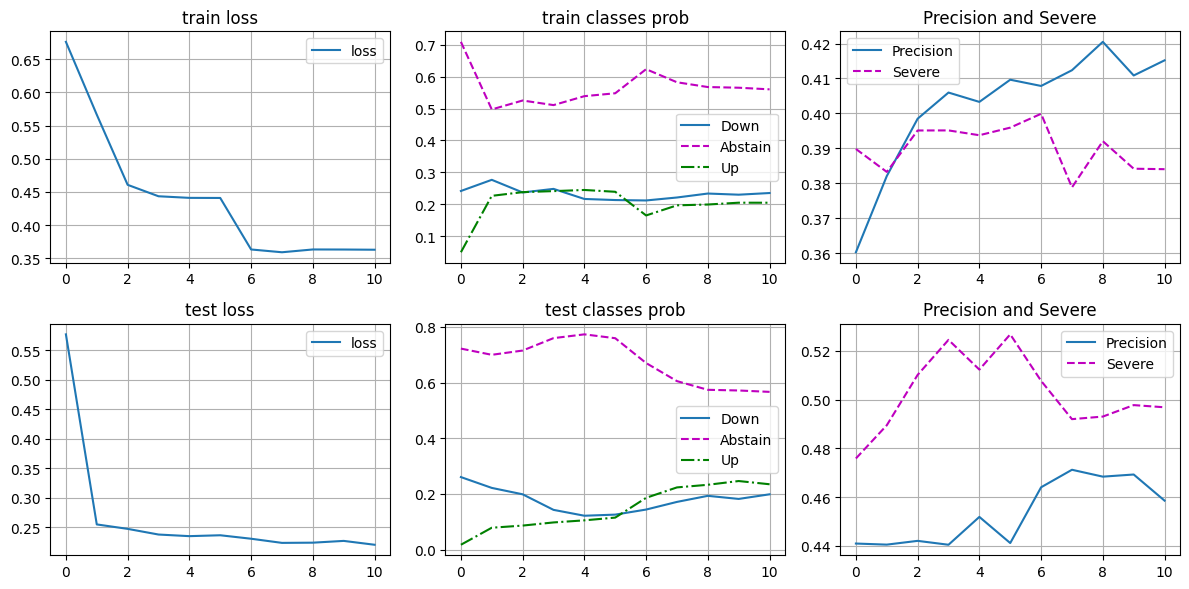

100%|██████████| 100/100 [00:00<00:00, 280.04it/s]


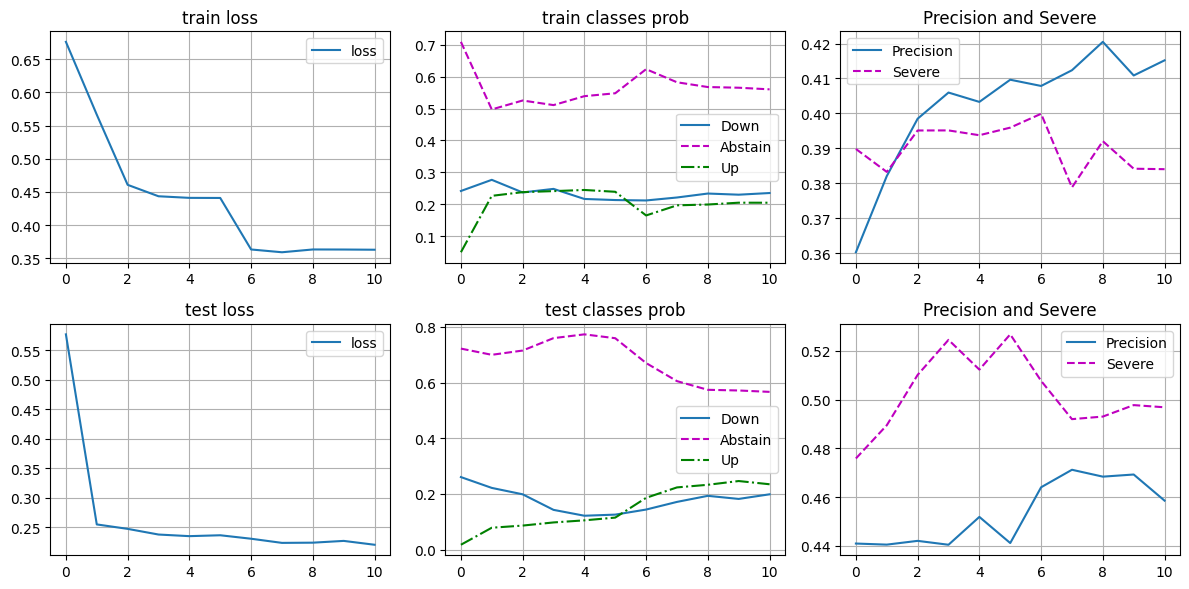

In [16]:
all_assets = pd.DataFrame(columns=[
            'asset',
            'stage_1_prediction', 'stage_2_prediction',
            'stage_1_precision', 'stage_2_precision',
            'stage_1_precision_std','stage_2_precision_std',
        ])
for code in assets_list:
    gap_1 = []
    prediction_1 = []
    gap_2 = []
    prediction_2 = []
    train_set_fine_tuning, validation_set_fine_tuning, test_set_fine_tuning = get_data_set([code])
    for i in range(10):

        animator.reset()
        model = DLinearOutput(seq_len = 40, pred_len = 5, individual = True, enc_in = 5, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
        loss_fn = HybridLoss(alpha = 1e-3, delta = 1)


        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        train = ModelTrain(model = model,
                        batch_size = 100,
                    train_set = train_set,
                    validation_set = validation_set_fine_tuning,
                    test_set = test_set_fine_tuning,
                    loss_fn = loss_fn,
                    optimizer = optimizer,
                    scheduler=scheduler,
                    recorder=recorder,
                    graph=animator,
                    )
        prediction, precision = train.epoch_train(epochs = 5, round = 100, early_stop = 10)
        gap_1.append(precision)
        prediction_1.append(prediction)

        train.train_set = train_set_fine_tuning

        prediction, precision = train.epoch_train(epochs = 5, round = 100, early_stop = 10)

        gap_2.append(precision)
        prediction_2.append(prediction)

    new_records = pd.DataFrame({
        'asset':[code],
        'stage_1_prediction': [np.mean(prediction_1)], 
        'stage_2_prediction': [np.mean(prediction_2)], 

        'stage_1_precision': [np.mean(gap_1)],  
        'stage_2_precision': [np.mean(gap_2)], 
        
        'stage_1_precision_std': [np.std(gap_1)], 
        'stage_2_precision_std': [np.std(gap_2)], 
        })
    
    all_assets = pd.concat([all_assets, new_records], ignore_index=True)

In [ ]:
all_assets_styled = all_assets.style.format({
    'stage_1_prediction': '{:.1%}',
    'stage_1_precision': '{:.1%}',
    'stage_1_precision_std': '{:.1%}',
    'stage_2_prediction': '{:.1%}',
    'stage_2_precision': '{:.1%}',
    'stage_2_precision_std': '{:.1%}',
})
all_assets.index = pd.Series(assets_list)
for col in all_assets.columns:
    all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# 转换为Markdown
markdown_table = all_assets.to_markdown(index=False)
# print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
print(markdown_table)

,asset,stage_1_prediction,stage_2_prediction,stage_1_precision,stage_2_precision,stage_1_precision_std,stage_2_precision_std
0,IH.CFX,16.9%,10.5%,11.9%,17.0%,10.3%,10.4%
1,IF.CFX,16.2%,9.1%,7.9%,16.3%,4.8%,6.2%
2,IC.CFX,23.8%,14.2%,7.3%,11.0%,6.5%,6.8%
3,AU.SHF,2.3%,13.9%,2.3%,0.5%,19.2%,8.5%
4,FU.SHF,80.5%,85.1%,3.2%,-0.6%,3.5%,1.8%
5,JM.DCE,84.4%,83.7%,2.3%,2.9%,2.6%,2.6%
6,RB.SHF,41.7%,46.1%,6.8%,5.2%,3.3%,1.6%
7,HC.SHF,40.3%,42.9%,2.7%,2.5%,4.1%,3.2%
8,I.DCE,88.7%,74.6%,3.2%,3.7%,1.9%,1.3%
9,M.DCE,24.0%,48.9%,6.3%,2.8%,7.3%,5.1%


可以看到，相比于单一学习的11%，多资产混合学习的7%，两阶段模式取得了显著的正确率提升，过拟合现象也有所缓解。

缺点仍然存在，在二阶段学习时，模型的预测比例仍然会回退到一阶段的10%左右。

In [ ]:
# asset	stage_1_prediction	stage_2_prediction	stage_1_precision	stage_2_precision	stage_1_precision_std	stage_2_precision_std
# 0	IH.CFX	34.5%	34.1%	6.5%	6.6%	5.0%	5.2%
# 1	IF.CFX	32.3%	32.2%	8.0%	8.0%	3.7%	3.3%
# 2	IC.CFX	42.3%	42.0%	1.3%	3.0%	4.3%	3.8%
# 3	AU.SHF	7.7%	8.0%	3.9%	3.0%	6.2%	7.0%
# 4	FU.SHF	92.4%	92.5%	1.3%	1.6%	1.9%	2.6%
# 5	JM.DCE	92.2%	92.3%	1.3%	1.3%	2.5%	2.1%
# 6	RB.SHF	60.9%	61.1%	4.5%	4.0%	2.1%	1.7%
# 7	HC.SHF	58.1%	58.5%	3.5%	3.2%	2.3%	2.5%
# 8	I.DCE	97.0%	96.8%	3.6%	3.6%	1.5%	1.6%
# 9	M.DCE	48.7%	48.8%	5.7%	6.5%	3.1%	3.8%
# 10	CF.ZCE	42.0%	41.8%	0.6%	1.1%	2.8%	3.0%